In [1]:
import yfinance as yf
import pandas as pd
import numpy as np

# Part 1. Electronic Arts
There will be 3 parts in total: Electronic Arts (first company), Paradox Interactive (second company), Portfolio analysis of both companies

In [3]:
name = 'EA'
ea_stock = yf.download(name, start='2020-04-22', end='2025-04-22')

company = yf.Ticker(name)
balance_sheet = company.balance_sheet
statement = company.financials

ea_data = pd.DataFrame(ea_stock)
ea_data.tail(10)

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,EA,EA,EA,EA,EA
Date,,,,,
2025-04-07,134.619995,136.750000,131.149994,132.960007,5825100
2025-04-08,132.529999,136.830002,131.160004,135.259995,3425700
2025-04-09,136.580002,140.589996,131.809998,131.839996,5410100
2025-04-10,139.389999,141.289993,135.429993,136.169998,3840900
2025-04-11,142.929993,143.440002,137.940002,139.389999,3116900
2025-04-14,145.500000,146.210007,142.509995,143.160004,2600400
2025-04-15,145.610001,146.289993,144.490005,145.660004,2277500
2025-04-16,142.970001,145.779999,142.690002,145.490005,2215800


# P/E and P/B ratio calculation

In [5]:
net_income = statement.loc['Net Income'].iloc[0]
share = balance_sheet.loc['Share Issued'].iloc[0]

earning_per_share = net_income / share
price_per_share = ea_stock['Close']

P_E_ratio = price_per_share / earning_per_share

book_value = balance_sheet.loc['Total Assets'].iloc[0] - balance_sheet.loc['Total Liabilities Net Minority Interest'].iloc[0]
shares_outstanding = company.info['sharesOutstanding']
book_value_per_share = book_value / shares_outstanding

P_B_ratio = price_per_share / book_value_per_share

ea_data['P/B ratio'] = P_B_ratio['EA']
ea_data['P/E ratio'] = P_E_ratio['EA']


print('P/E ratio for EA is: ' + str(P_E_ratio['EA'].iloc[-1]))
print('P/B ratio for EA is: ' + str(P_B_ratio['EA'].iloc[-1]))

ea_data.tail(5)

P/E ratio for EA is: 29.699237734999205
P/B ratio for EA is: 4.923400882627014


Price,Close,High,Low,Open,Volume,P/B ratio,P/E ratio
Ticker,EA,EA,EA,EA,EA,,
Date,,,,,,,
2025-04-14,145.500000,146.210007,142.509995,143.160004,2600400,5.047241,30.446271
2025-04-15,145.610001,146.289993,144.490005,145.660004,2277500,5.051056,30.469289
2025-04-16,142.970001,145.779999,142.690002,145.490005,2215800,4.959478,29.916862
2025-04-17,145.610001,146.089996,142.970001,143.270004,1761900,5.051056,30.469289
2025-04-21,141.929993,145.020004,141.039993,145.020004,2712300,4.923401,29.699238


#### Comparison with historical observations

In [7]:
print('Historical mean: ' + str(P_E_ratio['EA'][0::].mean()))
print('P/E ratio: ' + str(P_E_ratio['EA'].iloc[-1]))

Historical mean: 27.46890625806561
P/E ratio: 29.699237734999205


According to P/E, company is overvalued to fairly valued (~8 percent difference)

In [9]:
print('Historical mean: ' + str(P_B_ratio['EA'][0::].mean()))
print('P/B ratio: ' + str(P_B_ratio['EA'].iloc[-1]))

Historical mean: 4.553666950057247
P/B ratio: 4.923400882627014


Almost the same 8 percentage difference. Therefore, according to P/B, company is overvalued to fairly valued

# Discounted Cash Flow

#### Getting Free Cash Flow

In [13]:
cash_flow = company.cashflow
operating_cash_flow = cash_flow.loc['Operating Cash Flow', '2024']
operating_cash_flow = operating_cash_flow.iloc[0]
capital_expenditures = cash_flow.loc['Capital Expenditure', '2024']
capital_expenditures = capital_expenditures.iloc[0]
free_cash_flow = operating_cash_flow + capital_expenditures  
shares_outstanding = company.info['sharesOutstanding']

#### WACC for getting discount rate for DCF

In [15]:
#Assumptions
risk_free_rate = 0.04 # US Treasury Yield https://home.treasury.gov/resource-center/data-chart-center/interest-rates/TextView?type=daily_treasury_yield_curve&field_tdr_date_value=2025
market_return = 0.10 # Long-term average market return (S&P 500)
tax_rate = 0.21 #Standard tax rate

#Getting cost of debt
interest_expense = statement.loc["Interest Expense"]
total_debt = balance_sheet.loc["Total Debt"]
after_tax_cost_of_debt = interest_expense / total_debt * (1 - tax_rate)
cost_of_debt = after_tax_cost_of_debt.iloc[0]

equity_risk_premium = market_return - risk_free_rate
beta = company.info.get("beta", 1.0)
cost_of_equity = risk_free_rate + beta * equity_risk_premium

market_cap = company.info.get("marketCap", 0)
total_debt = company.info.get("totalDebt", 0)
cash = company.info.get("totalCash", 0)
enterprise_value = market_cap + total_debt - cash

E = market_cap
D = total_debt
V = E + D
debt_weight = D / V
equity_weight = E / V


wacc = (equity_weight * cost_of_equity) + (debt_weight * cost_of_debt * (1 - tax_rate))

#### DCF

In [17]:
discount_rate = wacc  
growth_rate = 0.04 #Long term forecast from https://simplywall.st/stocks/us/media/nasdaq-ea/electronic-arts/future?utm_source=chatgpt.com
years = 5  

future_cash_flows = []
for year in range(1, years + 1):
    future_cash_flow_value = free_cash_flow * ((1 + growth_rate) ** year)
    future_cash_flows.append(future_cash_flow_value)
    
dcf_values = []  
for year, fcf in enumerate(future_cash_flows, start=1):
    dcf_value = fcf / (1 + discount_rate) ** year
    dcf_values.append(dcf_value)
    
dcf_values = []
for year, fcf in enumerate(future_cash_flows, start=1):
    discounted_fcf = fcf / (1 + discount_rate) ** year 
    dcf_values.append(discounted_fcf)

terminal_value = future_cash_flows[-1] * (1 + growth_rate) / (discount_rate - growth_rate)
discounted_terminal_value = terminal_value / (1 + discount_rate) ** years
total_dcf = sum(dcf_values) + discounted_terminal_value

# DCF per share
dcf_per_share = total_dcf / shares_outstanding

# Output the results
print('Total DCF: ' + str(total_dcf))
print('DCF per share: ' + str(dcf_per_share))

Total DCF: 50736367901.337296
DCF per share: 194.67714394760645


In [18]:
ea_data.tail(5)

Price,Close,High,Low,Open,Volume,P/B ratio,P/E ratio
Ticker,EA,EA,EA,EA,EA,,
Date,,,,,,,
2025-04-14,145.500000,146.210007,142.509995,143.160004,2600400,5.047241,30.446271
2025-04-15,145.610001,146.289993,144.490005,145.660004,2277500,5.051056,30.469289
2025-04-16,142.970001,145.779999,142.690002,145.490005,2215800,4.959478,29.916862
2025-04-17,145.610001,146.089996,142.970001,143.270004,1761900,5.051056,30.469289
2025-04-21,141.929993,145.020004,141.039993,145.020004,2712300,4.923401,29.699238


The stock appears to be undervalued based on conducted DCF analysis.

# ROE, CAGR and Debt-To-Equity for assesing growth

#### Return on Equity

In [22]:
net_income = statement.loc['Net Income']  # Net income from the income statement
total_equity = balance_sheet.loc["Stockholders Equity"]  # Total equity from the balance sheet

# Calculate ROE for each year
roe = net_income / total_equity
print("Return on Equity (ROE):")
print(roe.iloc[0])

Return on Equity (ROE):
0.16943963796086783


#### Compund Annual Growth Rate

In [24]:
start_price = ea_data['Close'].iloc[0]
end_price = ea_data['Close'].iloc[-1]
num_years = 4

cagr = (end_price / start_price) ** (1 / num_years) - 1
print("Compound Annual Growth Rate: " + str(cagr.iloc[0]))

Compound Annual Growth Rate: 0.061547729348185864


#### Debt-to-Equity Ratio

In [26]:
total_debt = balance_sheet.loc["Total Debt"]
total_equity = balance_sheet.loc["Stockholders Equity"]

debt_to_equity_ratio = total_debt / total_equity

# Print the result
print("Debt-to-Equity Ratio: " + str(debt_to_equity_ratio.iloc[0]))

Debt-to-Equity Ratio: 0.2592839078929855


EA is in a good position considering provided metrics and is showing solid signs of growth  with strong financial health and a stable growth trajectory.

# Getting Betas for risk assesment

#### Loading Market Data

In [30]:
market = "^GSPC" #S&P 500
market_data = yf.download(market, start='2020-04-22', end='2025-04-22')
ea_close = ea_data['Close']
market_close = market_data['Close']

[*********************100%***********************]  1 of 1 completed


#### Getting Betas

In [32]:
returns = pd.DataFrame({
    "EA": ea_close['EA'].pct_change(),
    "Market": market_close['^GSPC'].pct_change()
})

In [33]:
covariance = np.cov(returns['EA'][1::], returns['Market'][1::])[0][1]
market_variance = np.var(returns['Market'][1::])
beta_EA = covariance / market_variance
print('EA Calculated Beta: ' + str(beta_EA))

EA Calculated Beta: 0.5345275630333721


Note: Our beta is different (no big difference) compared to official beta that can be found on Yahoo Finance, which is probably because of the fact of different time dimensions since in our example we use only 5-year period

Besides that, Beta shows low systematic risk, which is attractive to conservative investors

# Capital structure and the cost of capital assesment

Since we already calculated Debt to Equity and WACC we can use this parameters for evaluation 

In [38]:
print("WACC: " + str(wacc))
print("Debt-to-Equity Ratio: " + str(debt_to_equity_ratio.iloc[0]))

WACC: 0.08337401534692822
Debt-to-Equity Ratio: 0.2592839078929855


The cost of capital is moderate in magnitude, and this may reflect that the company is financially healthy with an equal mix of debt and equity.
The Debt-to-Equity Ratio of 0.259 is quite low and indicates the company is more focused on equity financing, which could be viewed positively in terms of lower financial risk.

# Dividend policy

In [41]:
earnings = company.financials.loc['Net Income', '2024'] # Net income from the latest available year
earnings = earnings.iloc[0]
dividend = company.dividends.mean() * 4  # Data provided in quarters, therefore we need to multiply by 4
dividend_payout_ratio = dividend / earnings 

dividend_history = company.dividends
dividend_growth = dividend_history.pct_change().mean()  # Average growth rate of dividends
    
print("Dividend payout ratio: " + str(dividend_payout_ratio))
print("Dividend growth: " + str(dividend_growth))
print("FCF: " + str(free_cash_flow)) #Since we calculated it previously
    

Dividend payout ratio: 5.760670332547787e-10
Dividend growth: 0.006920415224913497
FCF: 2116000000.0


Based on obtained parametrs: firm is most likely to be growth firm

# Part 2. Paradox Interactive

In [44]:
name = 'ETA.F'
Par_stock = yf.download(name, start='2020-04-22', end='2025-04-22')

company = yf.Ticker(name)
balance_sheet = company.balance_sheet
statement = company.financials

Par_data = pd.DataFrame(Par_stock)
Par_data.tail(10)

[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,ETA.F,ETA.F,ETA.F,ETA.F,ETA.F
Date,,,,,
2025-04-04,16.340000,16.340000,16.34,16.34,0
2025-04-07,15.540000,15.540000,15.12,15.12,20
2025-04-08,15.590000,15.590000,15.59,15.59,0
2025-04-09,15.180000,15.180000,15.18,15.18,0
2025-04-10,15.500000,15.520000,15.50,15.52,20
2025-04-11,15.560000,15.560000,15.56,15.56,0
2025-04-14,14.740000,14.740000,14.74,14.74,0
2025-04-15,15.950000,15.960000,15.17,15.17,620


# P/E and P/B ratio calculation

In [46]:
net_income = statement.loc['Net Income'].iloc[0]
share = balance_sheet.loc['Share Issued'].iloc[0]

earning_per_share = net_income / share
price_per_share = Par_stock['Close']

P_E_ratio = price_per_share / earning_per_share

book_value = balance_sheet.loc['Total Assets'].iloc[0] - balance_sheet.loc['Total Liabilities Net Minority Interest'].iloc[0]
shares_outstanding = company.info['sharesOutstanding']
book_value_per_share = book_value / shares_outstanding

P_B_ratio = price_per_share / book_value_per_share

Par_data['P/B ratio'] = P_B_ratio['ETA.F']
Par_data['P/E ratio'] = P_E_ratio['ETA.F']


print('P/E ratio for Paradox is: ' + str(P_E_ratio['ETA.F'].iloc[-1]))
print('P/B ratio for Paradox is: ' + str(P_B_ratio['ETA.F'].iloc[-1]))

Par_data.tail(5)

P/E ratio for Paradox is: 2.829246213631926
P/B ratio for Paradox is: 0.5684745067717


Price,Close,High,Low,Open,Volume,P/B ratio,P/E ratio
Ticker,ETA.F,ETA.F,ETA.F,ETA.F,ETA.F,,
Date,,,,,,,
2025-04-11,15.560000,15.560000,15.56,15.56,0,0.564844,2.811180
2025-04-14,14.740000,14.740000,14.74,14.74,0,0.535078,2.663032
2025-04-15,15.950000,15.960000,15.17,15.17,620,0.579002,2.881640
2025-04-16,16.190001,16.190001,15.56,15.56,14,0.587714,2.925000
2025-04-17,15.660000,15.660000,15.66,15.66,0,0.568475,2.829246


#### Comparison with historical observations

In [48]:
print('Historical mean: ' + str(P_E_ratio['ETA.F'][0::].mean()))
print('P/E ratio: ' + str(P_E_ratio['ETA.F'].iloc[-1]))

Historical mean: 2.4907845524216974
P/E ratio: 2.829246213631926


~14 percentage difference, slightly overvalued

In [50]:
print('Historical mean: ' + str(P_B_ratio['ETA.F'][0::].mean()))
print('P/B ratio: ' + str(P_B_ratio['ETA.F'].iloc[-1]))

Historical mean: 0.5004681151785765
P/B ratio: 0.5684745067717


Same difference, therefore according to P/B company is also slightly overvalued

# Discounted Cash Flow

#### Getting Free Cash Flow

In [54]:
cash_flow = company.cashflow
operating_cash_flow = cash_flow.loc['Operating Cash Flow', '2024']
operating_cash_flow = operating_cash_flow.iloc[0]
capital_expenditures = cash_flow.loc['Capital Expenditure', '2024']
capital_expenditures = capital_expenditures.iloc[0]
free_cash_flow = operating_cash_flow + capital_expenditures  
shares_outstanding = company.info['sharesOutstanding']

In [55]:
#Assumptions
risk_free_rate = 0.049 # US Treasury Yield https://home.treasury.gov/resource-center/data-chart-center/interest-rates/TextView?type=daily_treasury_yield_curve&field_tdr_date_value=2025
market_return = 0.08 # Long-term average market return (S&P 500)
tax_rate = 0.206 #Sweden Corporate Tax Rate

#Getting cost of debt
interest_expense = statement.loc["Interest Expense"]
total_debt = balance_sheet.loc["Total Debt"]
after_tax_cost_of_debt = interest_expense / total_debt * (1 - tax_rate)
cost_of_debt = after_tax_cost_of_debt.iloc[0]

equity_risk_premium = market_return - risk_free_rate
beta = company.info.get("beta", 1.0)
cost_of_equity = risk_free_rate + beta * equity_risk_premium

market_cap = company.info.get("marketCap", 0)
total_debt = company.info.get("totalDebt", 0)
cash = company.info.get("totalCash", 0)
enterprise_value = market_cap + total_debt - cash

E = market_cap
D = total_debt
V = E + D
debt_weight = D / V
equity_weight = E / V


wacc = (equity_weight * cost_of_equity) + (debt_weight * cost_of_debt * (1 - tax_rate))

#### DCF

In [57]:
discount_rate = wacc  
growth_rate = 0.02 #No public data found, therefore we will use standard conservative estimate  
years = 5  

future_cash_flows = []
for year in range(1, years + 1):
    future_cash_flow_value = free_cash_flow * ((1 + growth_rate) ** year)
    future_cash_flows.append(future_cash_flow_value)
    
dcf_values = []  
for year, fcf in enumerate(future_cash_flows, start=1):
    dcf_value = fcf / (1 + discount_rate) ** year
    dcf_values.append(dcf_value)
    
terminal_value = future_cash_flows[-1] * (1 + growth_rate) / (discount_rate - growth_rate)
discounted_terminal_value = terminal_value / (1 + discount_rate) ** years
total_dcf = sum(dcf_values) + discounted_terminal_value

# DCF per share
dcf_per_share = total_dcf / shares_outstanding

# Output the results
print('Total DCF: ' + str(total_dcf))
print('DCF per share: ' + str(dcf_per_share))

Total DCF: 16306053131.410225
DCF per share: 154.37975754722197


In [58]:
Par_data.tail(5)

Price,Close,High,Low,Open,Volume,P/B ratio,P/E ratio
Ticker,ETA.F,ETA.F,ETA.F,ETA.F,ETA.F,,
Date,,,,,,,
2025-04-11,15.560000,15.560000,15.56,15.56,0,0.564844,2.811180
2025-04-14,14.740000,14.740000,14.74,14.74,0,0.535078,2.663032
2025-04-15,15.950000,15.960000,15.17,15.17,620,0.579002,2.881640
2025-04-16,16.190001,16.190001,15.56,15.56,14,0.587714,2.925000
2025-04-17,15.660000,15.660000,15.66,15.66,0,0.568475,2.829246


Stocks are heavily undervalued, if we choose to proceed with this model, it can be explained by the fact that Paradox is said to be very sucessful recently due to the series of successful releases. It is also ranked as High Growth company according to following article: https://finance.yahoo.com/news/high-growth-tech-stocks-europe-050800782.html

# ROE, CAGR and Debt-To-Equity for assesing growth

In [61]:
net_income = statement.loc['Net Income']  # Net income from the income statement
total_equity = balance_sheet.loc["Stockholders Equity"]  # Total equity from the balance sheet

# Calculate ROE for each year
roe = net_income / total_equity
print("Return on Equity (ROE):")
print(roe.iloc[0])

Return on Equity (ROE):
0.2009279498494659


In [62]:
start_price = Par_data['Close'].iloc[0]
end_price = Par_data['Close'].iloc[-1]
num_years = 4

cagr = (end_price / start_price) ** (1 / num_years) - 1
print("Compound Annual Growth Rate: " + str(cagr.iloc[0]))

Compound Annual Growth Rate: 0.09409253550520447


In [63]:
total_debt = balance_sheet.loc["Total Debt"]
total_equity = balance_sheet.loc["Stockholders Equity"]

debt_to_equity_ratio = total_debt / total_equity

# Print the result
print("Debt-to-Equity Ratio: " + str(debt_to_equity_ratio.iloc[0]))

Debt-to-Equity Ratio: 0.022265984795369873


In this section we can observe high growth potential not based on debts, making firm very appealing in terms of growth

# Getting Betas for risk assesment

#### Loading Market Data

In [66]:
market = "^GSPC" #S&P 500
market_data = yf.download(market, start='2020-04-22', end='2025-04-22')
Par_close = Par_data['Close']
market_close = market_data['Close']

[*********************100%***********************]  1 of 1 completed


#### Getting Betas

In [68]:
returns = pd.DataFrame({
    "Paradox": Par_close['ETA.F'].pct_change(),
    "Market": market_close['^GSPC'].pct_change()
})

In [69]:
returns = returns.dropna()
covariance = np.cov(returns['Paradox'][1::], returns['Market'][1::])[0][1]
market_variance = np.var(returns['Market'][1::])
beta_Par = covariance / market_variance
print('Paradox Calculated Beta: ' + str(beta_Par))

Paradox Calculated Beta: 0.1419917840637029


Here Beta (no big difference as well) is also different but data contained missing values and it also has different time frame

What we can see here is that Beta is quite low, meaning now influence from the general market, once again good for conservative investors due to low risk

# Capital structure and the cost of capital assesment

In [72]:
print("WACC: " + str(wacc))
print("Debt-to-Equity Ratio: " + str(debt_to_equity_ratio.iloc[0]))

WACC: 0.05251841483201042
Debt-to-Equity Ratio: 0.022265984795369873


Low-risk capital structure based on DtE and a moderate cost of capital according to WACC, indicating stability but with not high return on equity

# Dividend policy

In [74]:
earnings = company.financials.loc['Net Income', '2024'] # Net income from the latest available year
earnings = earnings.iloc[0]
dividend = company.dividends.mean() * 4  # Data provided in quarters, therefore we need to multiply by 4
dividend_payout_ratio = dividend / earnings 

dividend_history = company.dividends
dividend_growth = dividend_history.pct_change().mean()  # Average growth rate of dividends
    
print("Dividend payout ratio: " + str(dividend_payout_ratio))
print("Dividend growth: " + str(dividend_growth))
print("FCF: " + str(free_cash_flow)) #Since we calculated it previously
    

Dividend payout ratio: 8.555354858132009e-10
Dividend growth: 0.21428571428571433
FCF: 519850000.0


Paradox appears to be growth firm as well

# Part 3. Portfolio Analysis

[*********************100%***********************]  2 of 2 completed
C:\Users\bogda\AppData\Local\Temp\ipykernel_6064\1394305715.py:6: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = df.pct_change()


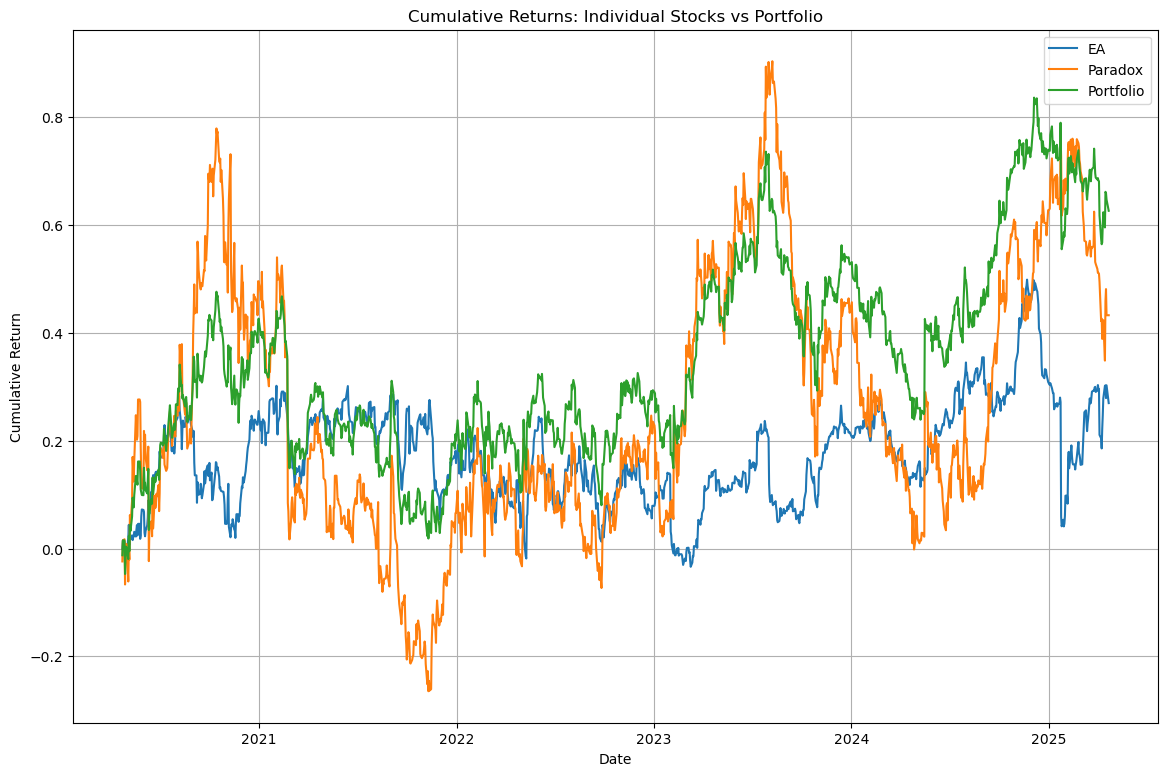

In [183]:
import matplotlib.pyplot as plt

companies = ['EA', 'ETA.F']

df = yf.download(companies, start='2020-04-22', end='2025-04-22')['Close']
returns = df.pct_change()
returns = returns.dropna()

mean_returns = returns.mean()
std_dev = returns.std()

weights = np.array([0.5, 0.5])
portfolio_return = np.dot(weights, mean_returns)
portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(returns.cov(), weights)))

plt.figure(figsize=(14, 9))
cumulative_returns = (1 + returns).cumprod() - 1
portfolio_cumulative_returns = (1 + np.dot(returns, weights)).cumprod() - 1

plt.plot(cumulative_returns['EA'], label="EA")
plt.plot(cumulative_returns['ETA.F'], label="Paradox")

portfolio_df = pd.DataFrame({
    'Date': cumulative_returns.index,  
    'Portfolio': portfolio_cumulative_returns
}) #This is just to get matching dates
portfolio_df.set_index('Date', inplace=True)

plt.plot(portfolio_df['Portfolio'], label="Portfolio")

plt.title('Cumulative Returns: Individual Stocks vs Portfolio')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend(loc='best')
plt.grid(True)
plt.show()

In [175]:
print("Expected Returns (Daily):")
print(mean_returns)
print("Volatilities (Daily Standard Deviation):")
print(std_dev)
print("Portfolio Expected Return:", portfolio_return)
print("Portfolio Volatility:", portfolio_volatility)

Expected Returns (Daily):
Ticker
EA       0.000308
ETA.F    0.000774
dtype: float64
Volatilities (Daily Standard Deviation):
Ticker
EA       0.015538
ETA.F    0.031663
dtype: float64
Portfolio Expected Return: 0.0005406732425613462
Portfolio Volatility: 0.018130665872880338


We can observe that portfolio return strikes a good balance between both both companies. While diversification may be a good idea looking only at returns, we shouldnt forget about volatilities. Volatilies also suggest balance between companies, scoring a point for portfolio. Therefore, portfolio is optimal choice if investors value balance between volatility and return